In [39]:
import sys
import os
import json
from pathlib import Path
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [40]:
# Add the project root to Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

##### 1. Import Search Functions

In [41]:
# Import the baseline TF-IDF search function
from src.baseline import search_baseline 

# Import the semantic search function
from src.semantic_search import semantic_search

print("✓ Imports successful!")

✓ Imports successful!


##### 2. Configuration

In [42]:
# Set paths relative to project root (parent of notebooks directory)
DATA_DIR = project_root / "data"
GOLDEN_DATASET_FILE = DATA_DIR / "golden_dataset.csv"
K_VALUE = 10

##### 3. Helper Functions

In [43]:
def calculate_precision_k(results: list[dict], relevant_doc_id: list[str], k: int) -> float:
    """
    Calculates Precision@k.
    'results' is a list of {'id': str, 'score': float}
    'doc_ids' is a list of one or more 'golden' IDs.
    """
    if k == 0:
        return 0.0
    
    top_k_ids = {res['id'] for res in results[:k]}
    relevant_ids_set = set(relevant_doc_id)
    
    hits = len(top_k_ids.intersection(relevant_ids_set))
    return hits / k

In [ ]:
def calculate_reciprocal_rank(results: list[dict], relevant_doc_id: list[str]) -> float:
    """
    Calculates the Reciprocal Rank.
    'results' is a list of {'id': str, 'score': float}
    'doc_ids' is a list of one or more 'golden' IDs.
    """
    relevant_ids_set = set(relevant_doc_id)
    
    for i, res in enumerate(results):
        rank = i + 1
        if res['id'] in relevant_ids_set:
            return 1.0 / rank
            
    return 0.0  # No relevant document found in the list

##### 4. Main Logic 

In [45]:
def main():
    print("Starting main logic...")
    print("Loading golden dataset...")
    try:
        golden_df = pl.read_csv(GOLDEN_DATASET_FILE)
        print("Golden dataset loaded successfully.")
    except Exception as e:
        print(f"Error loading golden dataset: {e}")
        return
    
    print(f"Loaded {len(golden_df)} queries from the golden dataset.")
    print("-" * 30)

    # Initialize lists to store results
    baseline_metrics = {'p_at_3': [], 'mrr': []}
    semantic_metrics = {'p_at_3': [], 'mrr': []}

    for i, row in enumerate(golden_df.iter_rows(named=True)):
        query = row['query_text']
        # Assumes the CSV stores the ID as a simple string.
        relevant_ids = [id.strip() for id in str(row['relevant_doc_ids']).split(',')]
        
        print(f"Processing query {i+1}/{len(golden_df)}: {query[:50]}...")

        # --- A. Test the Baseline Model ---
        baseline_results = search_baseline(query, n_results=K_VALUE)

        # Calculate metrics for baseline
        baseline_precision_at_3 = calculate_precision_k(baseline_results, relevant_ids, 3)
        baseline_mrr = calculate_reciprocal_rank(baseline_results, relevant_ids)

        baseline_metrics['p_at_3'].append(baseline_precision_at_3)
        baseline_metrics['mrr'].append(baseline_mrr)

        # --- B. Test the Semantic Search Model ---
        semantic_results = semantic_search(query, n_results=K_VALUE)

        # Calculate metrics for semantic search
        semantic_precision_at_3 = calculate_precision_k(semantic_results, relevant_ids, 3)
        semantic_mrr = calculate_reciprocal_rank(semantic_results, relevant_ids)

        semantic_metrics['p_at_3'].append(semantic_precision_at_3)
        semantic_metrics['mrr'].append(semantic_mrr)
    
    # Calculate and print average metrics
    avg_baseline_precision_at_3 = sum(baseline_metrics['p_at_3']) / len(baseline_metrics['p_at_3'])
    avg_baseline_mrr = sum(baseline_metrics['mrr']) / len(baseline_metrics['mrr'])
    
    avg_semantic_precision_at_3 = sum(semantic_metrics['p_at_3']) / len(semantic_metrics['p_at_3'])
    avg_semantic_mrr = sum(semantic_metrics['mrr']) / len(semantic_metrics['mrr'])
    
    print("\n--- Evaluation Complete ---")
    print(f"Metrics based on {len(golden_df)} queries (Top {K_VALUE} results):\n")
        
    print(f"{'Metric':<12} | {'Baseline (TF-IDF)':<18} | {'Semantic (SBERT)':<18}")
    print("-" * 52)
    print(f"{'Precision@3':<12} | {avg_baseline_precision_at_3:<18.4f} | {avg_semantic_precision_at_3:<18.4f}")
    print(f"{'MRR':<12} | {avg_baseline_mrr:<18.4f} | {avg_semantic_mrr:<18.4f}")
    print("-" * 52)

    # Return metrics 
    return {
        "avg_baseline_precision_at_3": avg_baseline_precision_at_3,
        "avg_baseline_mrr": avg_baseline_mrr,
        "avg_semantic_precision_at_3": avg_semantic_precision_at_3,
        "avg_semantic_mrr": avg_semantic_mrr,
        "num_queries": len(golden_df),
        "k_value": K_VALUE,
    }


##### 5. Aggregate and Print Results

In [46]:
# Call the main function to run the evaluation
main()

Starting main logic...
Loading golden dataset...
Golden dataset loaded successfully.
Loaded 30 queries from the golden dataset.
------------------------------
Processing query 1/30: what is linear regression...
Query vector shape: (1, 16252)
Query vector: [[0. 0. 0. ... 0. 0. 0.]]
Cosine similarities: [0. 0. 0. ... 0. 0. 0.]
Top 10 indices: [1544 1547 1741 1630 1708 1523 6359 1597 1543 6154]
Processing query 2/30: difference between random forest and gradient boos...
Query vector shape: (1, 16252)
Query vector: [[0. 0. 0. ... 0. 0. 0.]]
Cosine similarities: [0. 0. 0. ... 0. 0. 0.]
Top 10 indices: [2091 2114 2073 2092 2070 2093 2059 2104 1918 2094]
Processing query 3/30: can you provide information on TF-IDF...
Query vector shape: (1, 16252)
Query vector: [[0. 0. 0. ... 0. 0. 0.]]
Cosine similarities: [0. 0. 0. ... 0. 0. 0.]
Top 10 indices: [5598 5584 5574 5599 5592 5575 5591 5580 5576 5593]
Processing query 4/30: difference between data science and data engineeri...
Query vector shape:

{'avg_baseline_precision_at_3': 0.17777777777777773,
 'avg_baseline_mrr': 0.3389285714285714,
 'avg_semantic_precision_at_3': 0.45555555555555555,
 'avg_semantic_mrr': 0.6430555555555556,
 'num_queries': 30,
 'k_value': 10}

##### 6. Data Visual

In [57]:
def plot_metrics(metrics: dict) -> None:
    labels = ["Precision@3", "MRR"]
    baseline = [
        metrics["avg_baseline_precision_at_3"],
        metrics["avg_baseline_mrr"],
    ]
    semantic = [
        metrics["avg_semantic_precision_at_3"],
        metrics["avg_semantic_mrr"],
    ]

    x = np.arange(len(labels))
    width = 0.38

    plt.figure(figsize=(7, 4.5))
    if sns:
        sns.set_style("whitegrid")

    b1 = plt.bar(x - width/2, baseline, width, label="Baseline (TF-IDF)", color="#4C78A8")
    b2 = plt.bar(x + width/2, semantic, width, label="Semantic (SBERT)", color="#F58518")

    plt.xticks(x, labels)
    plt.ylabel("Score")
    plt.ylim(0, 1.0)
    plt.title("Search Metrics")
    plt.legend()

    for bars in (b1, b2):
        for bar in bars:
            h = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.2f}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()


Starting main logic...
Loading golden dataset...
Golden dataset loaded successfully.
Loaded 30 queries from the golden dataset.
------------------------------
Processing query 1/30: what is linear regression...
Query vector shape: (1, 16252)
Query vector: [[0. 0. 0. ... 0. 0. 0.]]
Cosine similarities: [0. 0. 0. ... 0. 0. 0.]
Top 10 indices: [1544 1547 1741 1630 1708 1523 6359 1597 1543 6154]
Processing query 2/30: difference between random forest and gradient boos...
Query vector shape: (1, 16252)
Query vector: [[0. 0. 0. ... 0. 0. 0.]]
Cosine similarities: [0. 0. 0. ... 0. 0. 0.]
Top 10 indices: [2091 2114 2073 2092 2070 2093 2059 2104 1918 2094]
Processing query 3/30: can you provide information on TF-IDF...
Query vector shape: (1, 16252)
Query vector: [[0. 0. 0. ... 0. 0. 0.]]
Cosine similarities: [0. 0. 0. ... 0. 0. 0.]
Top 10 indices: [5598 5584 5574 5599 5592 5575 5591 5580 5576 5593]
Processing query 4/30: difference between data science and data engineeri...
Query vector shape:

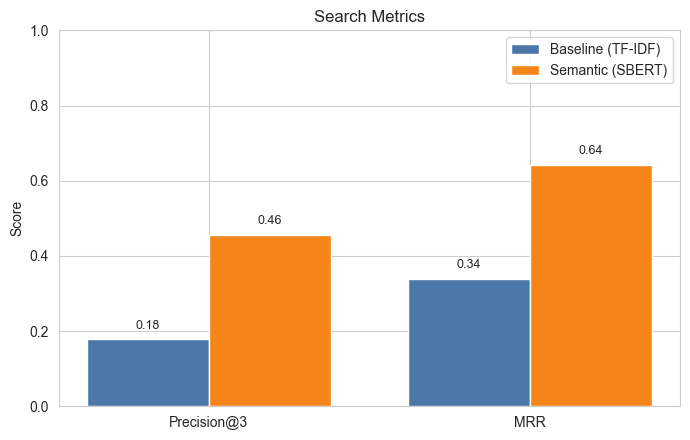

In [58]:
# Run evaluation and plot outside main()
metrics = main()
plot_metrics(metrics)
